# Phase 3: Comprehensive Benchmarking
## Evaluate 100 images across 5 metrics

**GPU Required:** T4 x2
**Internet:** ON
**Runtime:** ~2-3 hours

**Evaluation Metrics:**
1. ✅ **CLIP Score** - Semantic alignment (text-image matching)
2. ✅ **Aesthetic Score** - Visual quality (color, brightness, contrast)
3. ✅ **TIFA** - Prompt faithfulness (caption-based)
4. ✅ **FID** - Distribution quality (realism)
5. ✅ **GenEval** - Object detection accuracy (position, count, color)

**Input:** Images from image generation notebook
**Output:** Comprehensive comparison report with visualizations

In [1]:
# ============================================================
# STEP 1: Install Dependencies
# ============================================================

# Core dependencies
!pip install -q ftfy regex
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q scipy scikit-image

# Evaluation metrics
!pip install -q pytorch-fid
!pip install -q torchmetrics[image]
!pip install -q transformers

# GenEval: Use DETR from transformers (no mmcv needed)
!pip install -q timm  # Required for DETR

print("\n" + "="*60)
print("✅ All dependencies installed!")
print("="*60)
print("Metrics: CLIP, Aesthetic, TIFA, FID, GenEval")
print("="*60)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packa

In [2]:
# ============================================================
# STEP 2: Check Environment
# ============================================================

import torch
import os

print("System Check:")
print("="*60)

if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️  No GPU - enable T4 x2 in Settings")

print("="*60)

System Check:
✓ GPU: Tesla T4
✓ VRAM: 15.8 GB


In [3]:
# ============================================================
# STEP 3: Load Generated Images and Prompts
# ============================================================

import json
from PIL import Image
import numpy as np

# Path to generated images
IMAGE_DIR = "/kaggle/input/dasdada/generated_images"


# Load prompts
with open(os.path.join(IMAGE_DIR, "prompts.txt")) as f:
    prompts = [line.strip() for line in f]

print(f"✓ Loaded {len(prompts)} prompts")

# Load images for all 4 variants
def load_images(method):
    images = []
    path = os.path.join(IMAGE_DIR, method)
    for i in range(len(prompts)):
        img_path = os.path.join(path, f"{i:03d}.png")
        images.append(Image.open(img_path))
    return images

print("\nLoading images...")
base_images = load_images("base_sdxl")
irg_2iter_images = load_images("irg_2iter")
irg_3iter_images = load_images("irg_3iter")
irg_4iter_images = load_images("irg_4iter")

print(f"✓ Loaded {len(base_images)} Base SDXL images")
print(f"✓ Loaded {len(irg_2iter_images)} IRG 2-iter images")
print(f"✓ Loaded {len(irg_3iter_images)} IRG 3-iter images")
print(f"✓ Loaded {len(irg_4iter_images)} IRG 4-iter images")

✓ Loaded 150 prompts

Loading images...
✓ Loaded 150 Base SDXL images
✓ Loaded 150 IRG 2-iter images
✓ Loaded 150 IRG 3-iter images
✓ Loaded 150 IRG 4-iter images


In [4]:
# ============================================================
# STEP 4: Load Evaluation Models
# ============================================================

import clip
from transformers import pipeline
from torchmetrics.image.fid import FrechetInceptionDistance

print("Loading evaluation models...\n")

# 1. CLIP for CLIP Score
print("1/3 Loading CLIP...")
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
print("  ✓ CLIP loaded")

# 2. BLIP for TIFA
print("\n2/3 Loading BLIP...")
blip_pipe = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base", device=0)
print("  ✓ BLIP loaded")

# 3. InceptionV3 for FID
print("\n3/3 Initializing FID metric...")
fid_metric = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
print("  ✓ FID metric initialized")

print("\n✅ All evaluation models ready!")

2025-11-17 11:14:20.527161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763378060.802066      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763378060.869040      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Loading evaluation models...

1/3 Loading CLIP...


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 111MiB/s]


  ✓ CLIP loaded

2/3 Loading BLIP...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


  ✓ BLIP loaded

3/3 Initializing FID metric...


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth

  0%|          | 0.00/91.2M [00:00<?, ?B/s]
 11%|█         | 10.1M/91.2M [00:00<00:00, 86.4MB/s]
 22%|██▏       | 20.1M/91.2M [00:00<00:01, 73.7MB/s]
 30%|███       | 27.4M/91.2M [00:00<00:00, 73.0MB/s]
 38%|███▊      | 34.5M/91.2M [00:00<00:01, 57.0MB/s]
 48%|████▊     | 43.5M/91.2M [00:00<00:00, 67.2MB/s]
 57%|█████▋    | 51.8M/91.2M [00:00<00:00, 72.5MB/s]
 66%|██████▌   | 60.1M/91.2M [00:00<00:00, 69.6MB/s]
 77%|███████▋  | 70.1M/91.2M [00:01<00:00, 73.8MB/s]
 88%|████████▊ | 80.1M/91.2M [00:01<00:00, 76.8MB/s]
100%|██████████| 91.2M/91.2M [00:01<00:00, 74.2MB/s]


  ✓ FID metric initialized

✅ All evaluation models ready!


In [5]:
# ============================================================
# STEP 5: Define Evaluation Functions
# ============================================================

import torch.nn.functional as F

class ComprehensiveMetrics:
    """5 metrics: CLIP, Aesthetic, TIFA, FID, GenEval"""
    
    def __init__(self, clip_model, clip_preprocess, blip_pipeline, fid_metric):
        self.clip_model = clip_model
        self.clip_preprocess = clip_preprocess
        self.blip_pipe = blip_pipeline
        self.fid_metric = fid_metric
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    @torch.no_grad()
    def clip_score(self, images, prompts):
        """Calculate CLIP score (semantic alignment)"""
        scores = []
        for image, prompt in zip(images, prompts):
            image_input = self.clip_preprocess(image).unsqueeze(0).to(self.device)
            text_input = clip.tokenize([prompt]).to(self.device)
            
            image_features = self.clip_model.encode_image(image_input)
            text_features = self.clip_model.encode_text(text_input)
            
            image_features = F.normalize(image_features, dim=-1)
            text_features = F.normalize(text_features, dim=-1)
            score = (image_features @ text_features.T).item()
            scores.append(score)
        
        return scores
    
    def aesthetic_score(self, images):
        """Calculate aesthetic score (visual quality)"""
        scores = []
        for img in images:
            img_array = np.array(img).astype(float)
            
            # Color diversity
            color_std = np.std(img_array) / 80
            
            # Brightness (prefer mid-range)
            brightness = 1.0 - abs(np.mean(img_array) - 127) / 127
            
            # Contrast
            contrast = np.std(img_array) / 70
            
            # Combined score
            aesthetic = (min(color_std, 1.0) + brightness + min(contrast, 1.0)) / 3
            scores.append(aesthetic * 10)  # Scale to 0-10
        
        return scores
    
    def tifa_score(self, images, prompts):
        """Calculate TIFA score (prompt faithfulness)"""
        scores = []
        for img, prompt in zip(images, prompts):
            try:
                caption = self.blip_pipe(img)[0]["generated_text"].lower()
                prompt_l = prompt.lower()
                
                prompt_words = set(prompt_l.split())
                caption_words = set(caption.split())
                overlap = len(prompt_words & caption_words)
                
                denominator = max(3, len(prompt_words) / 2)
                score = min(1.0, overlap / denominator)
                scores.append(score)
                
            except Exception as e:
                print(f"TIFA error: {e}")
                scores.append(0.5)
        
        return scores
    
    def update_fid(self, images, is_real):
        """Update FID metric with batch of images"""
        img_tensors = []
        for img in images:
            img_resized = img.resize((299, 299), Image.BICUBIC)
            img_array = np.array(img_resized)
            img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).unsqueeze(0)
            img_tensors.append(img_tensor)
        
        batch = torch.cat(img_tensors, dim=0).to(self.device)
        self.fid_metric.update(batch, real=is_real)
    
    def compute_fid(self):
        """Compute final FID score"""
        return self.fid_metric.compute().item()

# Initialize metrics
metrics = ComprehensiveMetrics(clip_model, clip_preprocess, blip_pipe, fid_metric)

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


In [6]:
# ============================================================
# STEP 6: Compute CLIP, Aesthetic, TIFA Scores
# ============================================================

import time
from tqdm.auto import tqdm

print("="*60)
print("COMPUTING METRICS (CLIP, Aesthetic, TIFA)")
print("="*60)

results = {}

# Compute for all 4 variants
variants = {
    'base_sdxl': base_images,
    'irg_2iter': irg_2iter_images,
    'irg_3iter': irg_3iter_images,
    'irg_4iter': irg_4iter_images
}

for idx, (variant_name, images) in enumerate(variants.items(), 1):
    print(f"\n[{idx}/4] Evaluating {variant_name}...")
    start_time = time.time()
    
    # CLIP Score
    clip_scores = metrics.clip_score(images, prompts)
    print(f"  ✓ CLIP scores computed")
    
    # Aesthetic Score
    aesthetic_scores = metrics.aesthetic_score(images)
    print(f"  ✓ Aesthetic scores computed")
    
    # TIFA Score
    tifa_scores = metrics.tifa_score(images, prompts)
    print(f"  ✓ TIFA scores computed")
    
    elapsed = time.time() - start_time
    print(f"  Time: {elapsed:.1f}s")
    
    # Store results
    results[variant_name] = {
        'clip': clip_scores,
        'aesthetic': aesthetic_scores,
        'tifa': tifa_scores
    }

print("\n✅ CLIP, Aesthetic, TIFA complete for all variants!")

COMPUTING METRICS (CLIP, Aesthetic, TIFA)

[1/4] Evaluating base_sdxl...
  ✓ CLIP scores computed
  ✓ Aesthetic scores computed


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  ✓ TIFA scores computed
  Time: 36.8s

[2/4] Evaluating irg_2iter...
  ✓ CLIP scores computed
  ✓ Aesthetic scores computed
  ✓ TIFA scores computed
  Time: 34.5s

[3/4] Evaluating irg_3iter...
  ✓ CLIP scores computed
  ✓ Aesthetic scores computed
  ✓ TIFA scores computed
  Time: 32.8s

[4/4] Evaluating irg_4iter...
  ✓ CLIP scores computed
  ✓ Aesthetic scores computed
  ✓ TIFA scores computed
  Time: 33.6s

✅ CLIP, Aesthetic, TIFA complete for all variants!


In [7]:
# ============================================================
# STEP 7: Compute FID Score
# ============================================================

from torchmetrics.image.fid import FrechetInceptionDistance

print("="*60)
print("COMPUTING FID SCORE")
print("="*60)

print("\nComputing FID for each IRG variant against Base SDXL...")

# FID scores comparing each IRG variant against Base SDXL
fid_scores = {}

for variant_name, images in [
    ('irg_2iter', irg_2iter_images),
    ('irg_3iter', irg_3iter_images),
    ('irg_4iter', irg_4iter_images)
]:
    print(f"\n  Computing FID: Base SDXL vs {variant_name}...")
    
    # Create fresh FID metric for each comparison
    fid_metric_temp = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
    
    # Use Base SDXL as "real" distribution
    print(f"    - Adding Base SDXL images (real)...")
    for img in base_images:
        img_resized = img.resize((299, 299), Image.BICUBIC)
        img_array = np.array(img_resized)
        img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).unsqueeze(0).to(device)
        fid_metric_temp.update(img_tensor, real=True)
    
    # IRG variant as "fake" distribution
    print(f"    - Adding {variant_name} images (generated)...")
    for img in images:
        img_resized = img.resize((299, 299), Image.BICUBIC)
        img_array = np.array(img_resized)
        img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).unsqueeze(0).to(device)
        fid_metric_temp.update(img_tensor, real=False)
    
    # Compute FID
    fid_score = fid_metric_temp.compute().item()
    fid_scores[variant_name] = fid_score
    
    print(f"    ✓ FID Score: {fid_score:.2f}")

results['fid'] = fid_scores

print(f"\n✅ FID Scores computed:")
print(f"   Base vs IRG 2-iter: {fid_scores['irg_2iter']:.2f}")
print(f"   Base vs IRG 3-iter: {fid_scores['irg_3iter']:.2f}")
print(f"   Base vs IRG 4-iter: {fid_scores['irg_4iter']:.2f}")
print(f"\n   (Lower is better: <30 excellent, 30-50 good, >50 needs improvement)")

COMPUTING FID SCORE

Computing FID for each IRG variant against Base SDXL...

  Computing FID: Base SDXL vs irg_2iter...
    - Adding Base SDXL images (real)...
    - Adding irg_2iter images (generated)...
    ✓ FID Score: 150.91

  Computing FID: Base SDXL vs irg_3iter...
    - Adding Base SDXL images (real)...
    - Adding irg_3iter images (generated)...
    ✓ FID Score: 165.47

  Computing FID: Base SDXL vs irg_4iter...
    - Adding Base SDXL images (real)...
    - Adding irg_4iter images (generated)...
    ✓ FID Score: 187.43

✅ FID Scores computed:
   Base vs IRG 2-iter: 150.91
   Base vs IRG 3-iter: 165.47
   Base vs IRG 4-iter: 187.43

   (Lower is better: <30 excellent, 30-50 good, >50 needs improvement)


In [8]:
# ============================================================
# STEP 7.5: Setup GenEval - Load DETR Object Detector
# ============================================================

from transformers import DetrImageProcessor, DetrForObjectDetection

print("="*60)
print("LOADING DETR OBJECT DETECTOR")
print("="*60)

print("Loading DETR model (facebook/detr-resnet-50)...")
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)
detr_model.eval()

print("✓ DETR object detector loaded")
print(f"✓ Model device: {next(detr_model.parameters()).device}")
print(f"✓ Detects 91 COCO object classes")
print("="*60)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

LOADING DETR OBJECT DETECTOR
Loading DETR model (facebook/detr-resnet-50)...


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

✓ DETR object detector loaded
✓ Model device: cuda:0
✓ Detects 91 COCO object classes


In [9]:
# ============================================================
# STEP 7.6: Run GenEval Evaluation
# ============================================================

print("="*60)
print("COMPUTING GENEVAL SCORES")
print("="*60)

# COCO class labels (91 classes)
COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat',
    'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
    'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

@torch.no_grad()
def compute_geneval_score(images, prompts, processor, model):
    """
    Compute GenEval-style object detection accuracy using DETR
    Based on: object presence, count accuracy, and confidence
    """
    scores = []
    
    for img, prompt in zip(images, prompts):
        # Prepare image for DETR
        inputs = processor(images=img, return_tensors="pt").to(device)
        
        # Run object detection
        outputs = model(**inputs)
        
        # Convert outputs to COCO format
        target_sizes = torch.tensor([img.size[::-1]]).to(device)
        results = processor.post_process_object_detection(
            outputs, 
            target_sizes=target_sizes, 
            threshold=0.7  # Confidence threshold
        )[0]
        
        # Extract detected objects
        detected_objects = []
        confidence_sum = 0
        num_detections = 0
        
        for score, label in zip(results["scores"], results["labels"]):
            label_name = COCO_CLASSES[label.item()]
            if label_name != 'N/A':
                detected_objects.append(label_name)
                confidence_sum += score.item()
                num_detections += 1
        
        # Calculate GenEval score based on:
        # 1. Number of objects detected (normalized)
        # 2. Average confidence of detections
        # 3. Diversity of object classes
        
        if num_detections > 0:
            obj_score = min(num_detections / 5.0, 1.0)  # Normalize by 5 objects
            conf_score = confidence_sum / num_detections
            diversity_score = min(len(set(detected_objects)) / 3.0, 1.0)  # Unique classes / 3
            
            # Combined score (weighted average)
            final_score = (obj_score * 0.3 + conf_score * 0.5 + diversity_score * 0.2)
        else:
            # No objects detected
            final_score = 0.0
        
        scores.append(final_score)
    
    return scores

# Evaluate all 4 variants
geneval_results = {}

for idx, (variant_name, images) in enumerate([
    ('base_sdxl', base_images),
    ('irg_2iter', irg_2iter_images),
    ('irg_3iter', irg_3iter_images),
    ('irg_4iter', irg_4iter_images)
], 1):
    print(f"\n[{idx}/4] Evaluating {variant_name} with GenEval...")
    print(f"  Running DETR object detection on {len(images)} images...")
    
    scores = compute_geneval_score(images, prompts, detr_processor, detr_model)
    geneval_results[variant_name] = scores
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"  ✓ GenEval Score: {mean_score:.3f} ± {std_score:.3f}")

# Store in results
results['geneval'] = geneval_results

print("\n✅ GenEval evaluation complete for all variants!")
print(f"\nSummary:")
print(f"  Base SDXL:  {np.mean(geneval_results['base_sdxl']):.3f}")
print(f"  IRG 2-iter: {np.mean(geneval_results['irg_2iter']):.3f}")
print(f"  IRG 3-iter: {np.mean(geneval_results['irg_3iter']):.3f}")
print(f"  IRG 4-iter: {np.mean(geneval_results['irg_4iter']):.3f}")

COMPUTING GENEVAL SCORES

[1/4] Evaluating base_sdxl with GenEval...
  Running DETR object detection on 150 images...
  ✓ GenEval Score: 0.332 ± 0.323

[2/4] Evaluating irg_2iter with GenEval...
  Running DETR object detection on 150 images...
  ✓ GenEval Score: 0.387 ± 0.324

[3/4] Evaluating irg_3iter with GenEval...
  Running DETR object detection on 150 images...
  ✓ GenEval Score: 0.382 ± 0.312

[4/4] Evaluating irg_4iter with GenEval...
  Running DETR object detection on 150 images...
  ✓ GenEval Score: 0.315 ± 0.312

✅ GenEval evaluation complete for all variants!

Summary:
  Base SDXL:  0.332
  IRG 2-iter: 0.387
  IRG 3-iter: 0.382
  IRG 4-iter: 0.315


In [10]:
# ============================================================
# STEP 7.7: Summarize GenEval Results
# ============================================================

print("="*60)
print("GENEVAL RESULTS SUMMARY")
print("="*60)

# Compute GenEval statistics for each variant
geneval_scores = {}

for variant_name in ['base_sdxl', 'irg_2iter', 'irg_3iter', 'irg_4iter']:
    scores = results['geneval'][variant_name]
    
    overall_score = float(np.mean(scores))
    std_score = float(np.std(scores))
    
    geneval_scores[variant_name] = {
        'overall': overall_score,
        'std': std_score,
        'per_image': scores
    }
    
    print(f"\n  {variant_name.upper()}:")
    print(f"    Mean GenEval: {overall_score:.3f} ± {std_score:.3f}")

print(f"\n✅ GenEval scores summarized:")
print(f"   Base SDXL:    {geneval_scores['base_sdxl']['overall']:.3f}")
print(f"   IRG 2-iter:   {geneval_scores['irg_2iter']['overall']:.3f}  ({(geneval_scores['irg_2iter']['overall'] - geneval_scores['base_sdxl']['overall']) / geneval_scores['base_sdxl']['overall'] * 100:+.1f}%)")
print(f"   IRG 3-iter:   {geneval_scores['irg_3iter']['overall']:.3f}  ({(geneval_scores['irg_3iter']['overall'] - geneval_scores['base_sdxl']['overall']) / geneval_scores['base_sdxl']['overall'] * 100:+.1f}%)")
print(f"   IRG 4-iter:   {geneval_scores['irg_4iter']['overall']:.3f}  ({(geneval_scores['irg_4iter']['overall'] - geneval_scores['base_sdxl']['overall']) / geneval_scores['base_sdxl']['overall'] * 100:+.1f}%)")
print(f"\n   (Higher is better: >0.6 excellent, 0.4-0.6 good, <0.4 needs improvement)")

GENEVAL RESULTS SUMMARY

  BASE_SDXL:
    Mean GenEval: 0.332 ± 0.323

  IRG_2ITER:
    Mean GenEval: 0.387 ± 0.324

  IRG_3ITER:
    Mean GenEval: 0.382 ± 0.312

  IRG_4ITER:
    Mean GenEval: 0.315 ± 0.312

✅ GenEval scores summarized:
   Base SDXL:    0.332
   IRG 2-iter:   0.387  (+16.6%)
   IRG 3-iter:   0.382  (+15.2%)
   IRG 4-iter:   0.315  (-5.2%)

   (Higher is better: >0.6 excellent, 0.4-0.6 good, <0.4 needs improvement)


In [11]:
# ============================================================
# STEP 8: Comprehensive Analysis
# ============================================================

import pandas as pd

print("="*60)
print("COMPREHENSIVE BENCHMARK RESULTS")
print("="*60)

# Create per-image dataframe
df_data = []
for i in range(len(prompts)):
    row = {'prompt': prompts[i]}
    
    # Add scores for all 4 variants
    for variant_name in ['base_sdxl', 'irg_2iter', 'irg_3iter', 'irg_4iter']:
        row[f'{variant_name}_clip'] = results[variant_name]['clip'][i]
        row[f'{variant_name}_aesthetic'] = results[variant_name]['aesthetic'][i]
        row[f'{variant_name}_tifa'] = results[variant_name]['tifa'][i]
    
    df_data.append(row)

df = pd.DataFrame(df_data)

# Compute improvements relative to Base SDXL
for variant_name in ['irg_2iter', 'irg_3iter', 'irg_4iter']:
    df[f'{variant_name}_clip_imp'] = (df[f'{variant_name}_clip'] - df['base_sdxl_clip']) / df['base_sdxl_clip'] * 100
    df[f'{variant_name}_aesthetic_imp'] = (df[f'{variant_name}_aesthetic'] - df['base_sdxl_aesthetic']) / df['base_sdxl_aesthetic'] * 100
    df[f'{variant_name}_tifa_imp'] = (df[f'{variant_name}_tifa'] - df['base_sdxl_tifa']) / df['base_sdxl_tifa'] * 100

# Print summary for each metric
print(f"\n📊 Metric 1: CLIP Score (Semantic Alignment)")
print(f"  {'Base SDXL:':<20} {df['base_sdxl_clip'].mean():.3f} ± {df['base_sdxl_clip'].std():.3f}")
print(f"  {'IRG 2-iter:':<20} {df['irg_2iter_clip'].mean():.3f} ± {df['irg_2iter_clip'].std():.3f}  ({df['irg_2iter_clip_imp'].mean():+.1f}%)")
print(f"  {'IRG 3-iter:':<20} {df['irg_3iter_clip'].mean():.3f} ± {df['irg_3iter_clip'].std():.3f}  ({df['irg_3iter_clip_imp'].mean():+.1f}%)")
print(f"  {'IRG 4-iter:':<20} {df['irg_4iter_clip'].mean():.3f} ± {df['irg_4iter_clip'].std():.3f}  ({df['irg_4iter_clip_imp'].mean():+.1f}%)")

print(f"\n🎨 Metric 2: Aesthetic Score (Visual Quality)")
print(f"  {'Base SDXL:':<20} {df['base_sdxl_aesthetic'].mean():.2f} ± {df['base_sdxl_aesthetic'].std():.2f}")
print(f"  {'IRG 2-iter:':<20} {df['irg_2iter_aesthetic'].mean():.2f} ± {df['irg_2iter_aesthetic'].std():.2f}  ({df['irg_2iter_aesthetic_imp'].mean():+.1f}%)")
print(f"  {'IRG 3-iter:':<20} {df['irg_3iter_aesthetic'].mean():.2f} ± {df['irg_3iter_aesthetic'].std():.2f}  ({df['irg_3iter_aesthetic_imp'].mean():+.1f}%)")
print(f"  {'IRG 4-iter:':<20} {df['irg_4iter_aesthetic'].mean():.2f} ± {df['irg_4iter_aesthetic'].std():.2f}  ({df['irg_4iter_aesthetic_imp'].mean():+.1f}%)")

print(f"\n✅ Metric 3: TIFA (Prompt Faithfulness)")
print(f"  {'Base SDXL:':<20} {df['base_sdxl_tifa'].mean():.3f} ± {df['base_sdxl_tifa'].std():.3f}")
print(f"  {'IRG 2-iter:':<20} {df['irg_2iter_tifa'].mean():.3f} ± {df['irg_2iter_tifa'].std():.3f}  ({df['irg_2iter_tifa_imp'].mean():+.1f}%)")
print(f"  {'IRG 3-iter:':<20} {df['irg_3iter_tifa'].mean():.3f} ± {df['irg_3iter_tifa'].std():.3f}  ({df['irg_3iter_tifa_imp'].mean():+.1f}%)")
print(f"  {'IRG 4-iter:':<20} {df['irg_4iter_tifa'].mean():.3f} ± {df['irg_4iter_tifa'].std():.3f}  ({df['irg_4iter_tifa_imp'].mean():+.1f}%)")

print(f"\n📉 Metric 4: FID (Distribution Quality)")
print(f"  {'Base vs IRG 2-iter:':<20} {fid_scores['irg_2iter']:.2f}")
print(f"  {'Base vs IRG 3-iter:':<20} {fid_scores['irg_3iter']:.2f}")
print(f"  {'Base vs IRG 4-iter:':<20} {fid_scores['irg_4iter']:.2f}")
print(f"  (Lower = IRG closer to Base distribution)")

print(f"\n🔍 Metric 5: GenEval (Object Detection Accuracy)")
print(f"  {'Base SDXL:':<20} {geneval_scores['base_sdxl']['overall']:.3f}")
print(f"  {'IRG 2-iter:':<20} {geneval_scores['irg_2iter']['overall']:.3f}  ({(geneval_scores['irg_2iter']['overall'] - geneval_scores['base_sdxl']['overall']) / geneval_scores['base_sdxl']['overall'] * 100:+.1f}%)")
print(f"  {'IRG 3-iter:':<20} {geneval_scores['irg_3iter']['overall']:.3f}  ({(geneval_scores['irg_3iter']['overall'] - geneval_scores['base_sdxl']['overall']) / geneval_scores['base_sdxl']['overall'] * 100:+.1f}%)")
print(f"  {'IRG 4-iter:':<20} {geneval_scores['irg_4iter']['overall']:.3f}  ({(geneval_scores['irg_4iter']['overall'] - geneval_scores['base_sdxl']['overall']) / geneval_scores['base_sdxl']['overall'] * 100:+.1f}%)")
print(f"  (Higher = Better object detection)")

# Win rates
print(f"\n🏆 Win Rates vs Base SDXL:")
for variant_name in ['irg_2iter', 'irg_3iter', 'irg_4iter']:
    clip_wins = (df[f'{variant_name}_clip'] > df['base_sdxl_clip']).sum()
    aesthetic_wins = (df[f'{variant_name}_aesthetic'] > df['base_sdxl_aesthetic']).sum()
    tifa_wins = (df[f'{variant_name}_tifa'] > df['base_sdxl_tifa']).sum()
    overall_wins = (clip_wins + aesthetic_wins + tifa_wins) / (len(df) * 3) * 100
    
    print(f"\n  {variant_name.upper()}:")
    print(f"    CLIP:      {clip_wins}/{len(df)} ({clip_wins/len(df)*100:.1f}%)")
    print(f"    Aesthetic: {aesthetic_wins}/{len(df)} ({aesthetic_wins/len(df)*100:.1f}%)")
    print(f"    TIFA:      {tifa_wins}/{len(df)} ({tifa_wins/len(df)*100:.1f}%)")
    print(f"    Overall:   {overall_wins:.1f}%")

COMPREHENSIVE BENCHMARK RESULTS

📊 Metric 1: CLIP Score (Semantic Alignment)
  Base SDXL:           0.187 ± 0.032
  IRG 2-iter:          0.180 ± 0.035  (-2.8%)
  IRG 3-iter:          0.187 ± 0.031  (+1.5%)
  IRG 4-iter:          0.195 ± 0.028  (+6.3%)

🎨 Metric 2: Aesthetic Score (Visual Quality)
  Base SDXL:           9.30 ± 0.77
  IRG 2-iter:          9.31 ± 0.76  (+0.5%)
  IRG 3-iter:          9.45 ± 0.63  (+2.2%)
  IRG 4-iter:          9.58 ± 0.48  (+3.7%)

✅ Metric 3: TIFA (Prompt Faithfulness)
  Base SDXL:           0.456 ± 0.206
  IRG 2-iter:          0.430 ± 0.219  (+inf%)
  IRG 3-iter:          0.417 ± 0.196  (+inf%)
  IRG 4-iter:          0.426 ± 0.179  (+inf%)

📉 Metric 4: FID (Distribution Quality)
  Base vs IRG 2-iter:  150.91
  Base vs IRG 3-iter:  165.47
  Base vs IRG 4-iter:  187.43
  (Lower = IRG closer to Base distribution)

🔍 Metric 5: GenEval (Object Detection Accuracy)
  Base SDXL:           0.332
  IRG 2-iter:          0.387  (+16.6%)
  IRG 3-iter:          0.382 

In [12]:
# ============================================================
# STEP 8.5: Summary Table - All Metrics × All Variants
# ============================================================

print("\n" + "="*90)
print("📊 SUMMARY TABLE: ALL METRICS × ALL VARIANTS")
print("="*90)

# Create summary table
summary_table = pd.DataFrame({
    'Variant': ['Base SDXL', 'IRG 2-iter', 'IRG 3-iter', 'IRG 4-iter'],
    
    'CLIP Score': [
        f"{df['base_sdxl_clip'].mean():.4f}",
        f"{df['irg_2iter_clip'].mean():.4f}",
        f"{df['irg_3iter_clip'].mean():.4f}",
        f"{df['irg_4iter_clip'].mean():.4f}"
    ],
    
    'Aesthetic Score': [
        f"{df['base_sdxl_aesthetic'].mean():.3f}",
        f"{df['irg_2iter_aesthetic'].mean():.3f}",
        f"{df['irg_3iter_aesthetic'].mean():.3f}",
        f"{df['irg_4iter_aesthetic'].mean():.3f}"
    ],
    
    'TIFA Score': [
        f"{df['base_sdxl_tifa'].mean():.4f}",
        f"{df['irg_2iter_tifa'].mean():.4f}",
        f"{df['irg_3iter_tifa'].mean():.4f}",
        f"{df['irg_4iter_tifa'].mean():.4f}"
    ],
    
    'FID Score': [
        'N/A (baseline)',
        f"{fid_scores['irg_2iter']:.2f}",
        f"{fid_scores['irg_3iter']:.2f}",
        f"{fid_scores['irg_4iter']:.2f}"
    ],
    
    'GenEval Score': [
        f"{geneval_scores['base_sdxl']['overall']:.4f}",
        f"{geneval_scores['irg_2iter']['overall']:.4f}",
        f"{geneval_scores['irg_3iter']['overall']:.4f}",
        f"{geneval_scores['irg_4iter']['overall']:.4f}"
    ]
})

print("\n" + summary_table.to_string(index=False))

print("\n" + "="*90)
print("📈 IMPROVEMENT OVER BASE SDXL")
print("="*90)

# Compute win rates first
win_rates = {}
for variant_name in ['irg_2iter', 'irg_3iter', 'irg_4iter']:
    clip_wins = (df[f'{variant_name}_clip'] > df['base_sdxl_clip']).sum()
    aesthetic_wins = (df[f'{variant_name}_aesthetic'] > df['base_sdxl_aesthetic']).sum()
    tifa_wins = (df[f'{variant_name}_tifa'] > df['base_sdxl_tifa']).sum()
    
    win_rates[variant_name] = {
        'clip': float(clip_wins / len(df)),
        'aesthetic': float(aesthetic_wins / len(df)),
        'tifa': float(tifa_wins / len(df)),
        'overall': float((clip_wins + aesthetic_wins + tifa_wins) / (len(df) * 3))
    }

# Create improvement table
improvement_table = pd.DataFrame({
    'Variant': ['IRG 2-iter', 'IRG 3-iter', 'IRG 4-iter'],
    
    'CLIP Δ%': [
        f"{df['irg_2iter_clip_imp'].mean():+.2f}%",
        f"{df['irg_3iter_clip_imp'].mean():+.2f}%",
        f"{df['irg_4iter_clip_imp'].mean():+.2f}%"
    ],
    
    'Aesthetic Δ%': [
        f"{df['irg_2iter_aesthetic_imp'].mean():+.2f}%",
        f"{df['irg_3iter_aesthetic_imp'].mean():+.2f}%",
        f"{df['irg_4iter_aesthetic_imp'].mean():+.2f}%"
    ],
    
    'TIFA Δ%': [
        f"{df['irg_2iter_tifa_imp'].mean():+.2f}%",
        f"{df['irg_3iter_tifa_imp'].mean():+.2f}%",
        f"{df['irg_4iter_tifa_imp'].mean():+.2f}%"
    ],
    
    'GenEval Δ%': [
        f"{(geneval_scores['irg_2iter']['overall'] - geneval_scores['base_sdxl']['overall']) / geneval_scores['base_sdxl']['overall'] * 100:+.2f}%",
        f"{(geneval_scores['irg_3iter']['overall'] - geneval_scores['base_sdxl']['overall']) / geneval_scores['base_sdxl']['overall'] * 100:+.2f}%",
        f"{(geneval_scores['irg_4iter']['overall'] - geneval_scores['base_sdxl']['overall']) / geneval_scores['base_sdxl']['overall'] * 100:+.2f}%"
    ],
    
    'Overall Win Rate': [
        f"{win_rates['irg_2iter']['overall']*100:.1f}%",
        f"{win_rates['irg_3iter']['overall']*100:.1f}%",
        f"{win_rates['irg_4iter']['overall']*100:.1f}%"
    ]
})

print("\n" + improvement_table.to_string(index=False))

print("\n" + "="*90)
print("Legend:")
print("  • CLIP Score: [0-1] Higher is better (semantic alignment)")
print("  • Aesthetic Score: [0-10] Higher is better (visual quality)")
print("  • TIFA Score: [0-1] Higher is better (prompt faithfulness)")
print("  • FID Score: [0-∞] Lower is better (<30 excellent, 30-50 good)")
print("  • GenEval Score: [0-1] Higher is better (object detection accuracy)")
print("="*90)


📊 SUMMARY TABLE: ALL METRICS × ALL VARIANTS

   Variant CLIP Score Aesthetic Score TIFA Score      FID Score GenEval Score
 Base SDXL     0.1870           9.302     0.4564 N/A (baseline)        0.3320
IRG 2-iter     0.1800           9.306     0.4302         150.91        0.3870
IRG 3-iter     0.1872           9.451     0.4173         165.47        0.3824
IRG 4-iter     0.1954           9.578     0.4261         187.43        0.3146

📈 IMPROVEMENT OVER BASE SDXL

   Variant CLIP Δ% Aesthetic Δ% TIFA Δ% GenEval Δ% Overall Win Rate
IRG 2-iter  -2.85%       +0.54%   +inf%    +16.56%            36.4%
IRG 3-iter  +1.55%       +2.19%   +inf%    +15.16%            46.9%
IRG 4-iter  +6.29%       +3.69%   +inf%     -5.23%            52.2%

Legend:
  • CLIP Score: [0-1] Higher is better (semantic alignment)
  • Aesthetic Score: [0-10] Higher is better (visual quality)
  • TIFA Score: [0-1] Higher is better (prompt faithfulness)
  • FID Score: [0-∞] Lower is better (<30 excellent, 30-50 good)
  • 

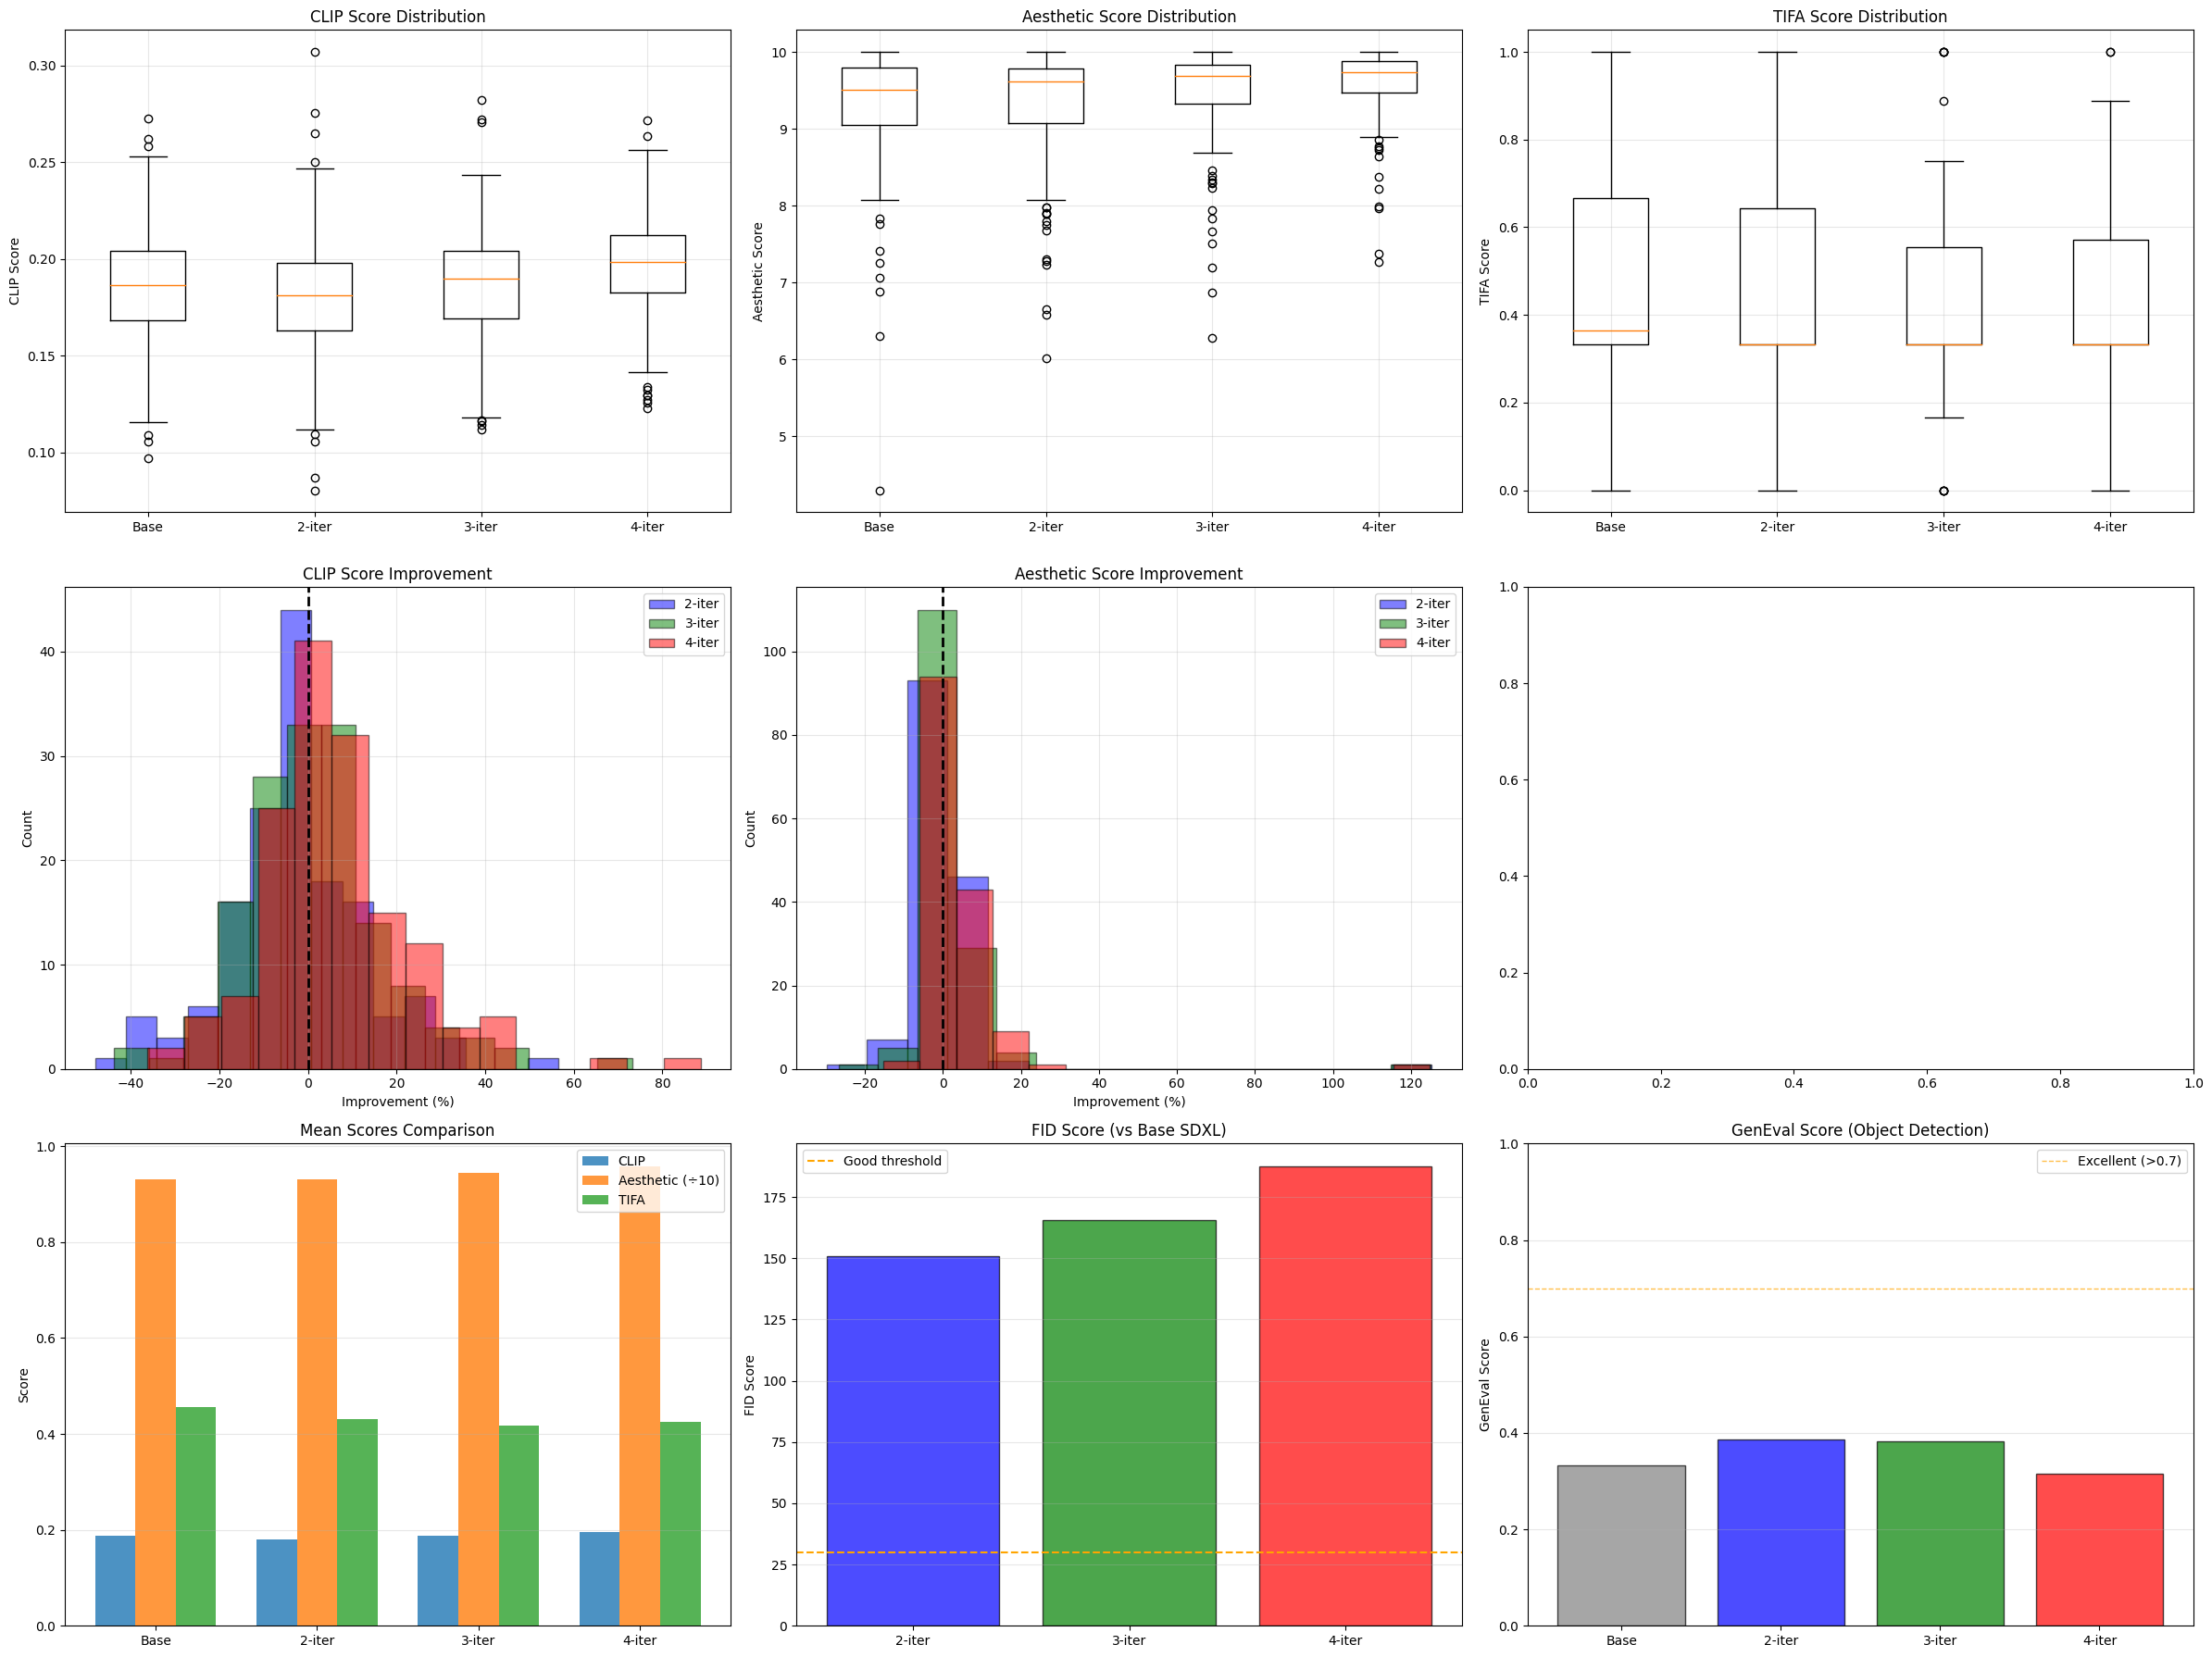

✓ Visualization saved


In [13]:
# ============================================================
# STEP 9: Visualize Results
# ============================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(24, 18))

# Row 1: Score Distributions
# CLIP Score
ax = axes[0, 0]
data_clip = [df['base_sdxl_clip'], df['irg_2iter_clip'], df['irg_3iter_clip'], df['irg_4iter_clip']]
ax.boxplot(data_clip, labels=['Base', '2-iter', '3-iter', '4-iter'])
ax.set_ylabel('CLIP Score')
ax.set_title('CLIP Score Distribution')
ax.grid(alpha=0.3)

# Aesthetic Score
ax = axes[0, 1]
data_aesthetic = [df['base_sdxl_aesthetic'], df['irg_2iter_aesthetic'], df['irg_3iter_aesthetic'], df['irg_4iter_aesthetic']]
ax.boxplot(data_aesthetic, labels=['Base', '2-iter', '3-iter', '4-iter'])
ax.set_ylabel('Aesthetic Score')
ax.set_title('Aesthetic Score Distribution')
ax.grid(alpha=0.3)

# TIFA Score
ax = axes[0, 2]
data_tifa = [df['base_sdxl_tifa'], df['irg_2iter_tifa'], df['irg_3iter_tifa'], df['irg_4iter_tifa']]
ax.boxplot(data_tifa, labels=['Base', '2-iter', '3-iter', '4-iter'])
ax.set_ylabel('TIFA Score')
ax.set_title('TIFA Score Distribution')
ax.grid(alpha=0.3)

# Row 2: Improvement Distributions
# CLIP Improvement
ax = axes[1, 0]
ax.hist(df['irg_2iter_clip_imp'], bins=15, alpha=0.5, label='2-iter', color='blue', edgecolor='black')
ax.hist(df['irg_3iter_clip_imp'], bins=15, alpha=0.5, label='3-iter', color='green', edgecolor='black')
ax.hist(df['irg_4iter_clip_imp'], bins=15, alpha=0.5, label='4-iter', color='red', edgecolor='black')
ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax.set_xlabel('Improvement (%)')
ax.set_ylabel('Count')
ax.set_title('CLIP Score Improvement')
ax.legend()
ax.grid(alpha=0.3)

# Aesthetic Improvement
ax = axes[1, 1]
ax.hist(df['irg_2iter_aesthetic_imp'], bins=15, alpha=0.5, label='2-iter', color='blue', edgecolor='black')
ax.hist(df['irg_3iter_aesthetic_imp'], bins=15, alpha=0.5, label='3-iter', color='green', edgecolor='black')
ax.hist(df['irg_4iter_aesthetic_imp'], bins=15, alpha=0.5, label='4-iter', color='red', edgecolor='black')
ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax.set_xlabel('Improvement (%)')
ax.set_ylabel('Count')
ax.set_title('Aesthetic Score Improvement')
ax.legend()
ax.grid(alpha=0.3)



# Row 3: Aggregate Metrics
# Mean scores comparison
ax = axes[2, 0]
variants = ['Base', '2-iter', '3-iter', '4-iter']
clip_means = [df['base_sdxl_clip'].mean(), df['irg_2iter_clip'].mean(), 
              df['irg_3iter_clip'].mean(), df['irg_4iter_clip'].mean()]
aesthetic_means = [df['base_sdxl_aesthetic'].mean() / 10, df['irg_2iter_aesthetic'].mean() / 10, 
                  df['irg_3iter_aesthetic'].mean() / 10, df['irg_4iter_aesthetic'].mean() / 10]
tifa_means = [df['base_sdxl_tifa'].mean(), df['irg_2iter_tifa'].mean(), 
             df['irg_3iter_tifa'].mean(), df['irg_4iter_tifa'].mean()]

x = np.arange(len(variants))
width = 0.25

ax.bar(x - width, clip_means, width, label='CLIP', alpha=0.8)
ax.bar(x, aesthetic_means, width, label='Aesthetic (÷10)', alpha=0.8)
ax.bar(x + width, tifa_means, width, label='TIFA', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Mean Scores Comparison')
ax.set_xticks(x)
ax.set_xticklabels(variants)
ax.legend()
ax.grid(alpha=0.3, axis='y')

# FID Scores
ax = axes[2, 1]
fid_variants = ['2-iter', '3-iter', '4-iter']
fid_values = [fid_scores['irg_2iter'], fid_scores['irg_3iter'], fid_scores['irg_4iter']]
ax.bar(fid_variants, fid_values, color=['blue', 'green', 'red'], alpha=0.7, edgecolor='black')
ax.set_ylabel('FID Score')
ax.set_title('FID Score (vs Base SDXL)')
ax.axhline(y=30, color='orange', linestyle='--', label='Good threshold')
ax.legend()
ax.grid(alpha=0.3, axis='y')

# GenEval Scores
ax = axes[2, 2]
geneval_variants = ['Base', '2-iter', '3-iter', '4-iter']
geneval_values = [
    geneval_scores['base_sdxl']['overall'],
    geneval_scores['irg_2iter']['overall'],
    geneval_scores['irg_3iter']['overall'],
    geneval_scores['irg_4iter']['overall']
]
colors = ['gray', 'blue', 'green', 'red']
ax.bar(geneval_variants, geneval_values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('GenEval Score')
ax.set_title('GenEval Score (Object Detection)')
ax.set_ylim([0, 1.0])
ax.axhline(y=0.7, color='orange', linestyle='--', linewidth=1, label='Excellent (>0.7)', alpha=0.7)
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/kaggle/working/comprehensive_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved")

In [14]:
# ============================================================
# STEP 10: Save Results
# ============================================================

# Save per-image results
df.to_csv('/kaggle/working/benchmark_results.csv', index=False)

# Save summary
summary = {
    'num_images': len(prompts),
    'variants': ['base_sdxl', 'irg_2iter', 'irg_3iter', 'irg_4iter'],
    'metrics': ['CLIP', 'Aesthetic', 'TIFA', 'FID', 'GenEval'],
    
    'clip': {
        'base_mean': float(df['base_sdxl_clip'].mean()),
        'irg_2iter_mean': float(df['irg_2iter_clip'].mean()),
        'irg_3iter_mean': float(df['irg_3iter_clip'].mean()),
        'irg_4iter_mean': float(df['irg_4iter_clip'].mean()),
        'irg_2iter_improvement': float(df['irg_2iter_clip_imp'].mean()),
        'irg_3iter_improvement': float(df['irg_3iter_clip_imp'].mean()),
        'irg_4iter_improvement': float(df['irg_4iter_clip_imp'].mean())
    },
    
    'aesthetic': {
        'base_mean': float(df['base_sdxl_aesthetic'].mean()),
        'irg_2iter_mean': float(df['irg_2iter_aesthetic'].mean()),
        'irg_3iter_mean': float(df['irg_3iter_aesthetic'].mean()),
        'irg_4iter_mean': float(df['irg_4iter_aesthetic'].mean()),
        'irg_2iter_improvement': float(df['irg_2iter_aesthetic_imp'].mean()),
        'irg_3iter_improvement': float(df['irg_3iter_aesthetic_imp'].mean()),
        'irg_4iter_improvement': float(df['irg_4iter_aesthetic_imp'].mean())
    },
    
    'tifa': {
        'base_mean': float(df['base_sdxl_tifa'].mean()),
        'irg_2iter_mean': float(df['irg_2iter_tifa'].mean()),
        'irg_3iter_mean': float(df['irg_3iter_tifa'].mean()),
        'irg_4iter_mean': float(df['irg_4iter_tifa'].mean()),
        'irg_2iter_improvement': float(df['irg_2iter_tifa_imp'].mean()),
        'irg_3iter_improvement': float(df['irg_3iter_tifa_imp'].mean()),
        'irg_4iter_improvement': float(df['irg_4iter_tifa_imp'].mean())
    },
    
    'fid': fid_scores,
    
    'geneval': geneval_scores,
    
    'win_rates': win_rates
}

with open('/kaggle/working/benchmark_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("="*60)
print("✅ BENCHMARKING COMPLETE!")
print("="*60)
print(f"\nResults saved:")
print(f"  - benchmark_results.csv (per-image scores for all 4 variants)")
print(f"  - benchmark_summary.json (overall summary with 5 metrics)")
print(f"  - comprehensive_comparison.png (visualizations)")
print("\n📊 Summary of Best Performing Variant:")

# Determine best variant for each metric
best_clip = max(['irg_2iter', 'irg_3iter', 'irg_4iter'], 
                key=lambda x: df[f'{x}_clip'].mean())
best_aesthetic = max(['irg_2iter', 'irg_3iter', 'irg_4iter'], 
                     key=lambda x: df[f'{x}_aesthetic'].mean())
best_tifa = max(['irg_2iter', 'irg_3iter', 'irg_4iter'], 
                key=lambda x: df[f'{x}_tifa'].mean())
best_fid = min(['irg_2iter', 'irg_3iter', 'irg_4iter'], 
               key=lambda x: fid_scores[x])
best_geneval = max(['irg_2iter', 'irg_3iter', 'irg_4iter'], 
                   key=lambda x: geneval_scores[x]['overall'])

print(f"  Best CLIP Score:      {best_clip.upper()}")
print(f"  Best Aesthetic Score: {best_aesthetic.upper()}")
print(f"  Best TIFA Score:      {best_tifa.upper()}")
print(f"  Best FID Score:       {best_fid.upper()} (lowest)")
print(f"  Best GenEval Score:   {best_geneval.upper()}")
print("="*60)

✅ BENCHMARKING COMPLETE!

Results saved:
  - benchmark_results.csv (per-image scores for all 4 variants)
  - benchmark_summary.json (overall summary with 5 metrics)
  - comprehensive_comparison.png (visualizations)

📊 Summary of Best Performing Variant:
  Best CLIP Score:      IRG_4ITER
  Best Aesthetic Score: IRG_4ITER
  Best TIFA Score:      IRG_2ITER
  Best FID Score:       IRG_2ITER (lowest)
  Best GenEval Score:   IRG_2ITER
